# Model 1

XGB Boost Model

In [1]:
! pip install -r requirements.txt

In [18]:
#
# basics
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('magma')
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error


# warnings
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

# EDA

In [19]:
# load training data
df = pd.read_csv('data/Train.csv')

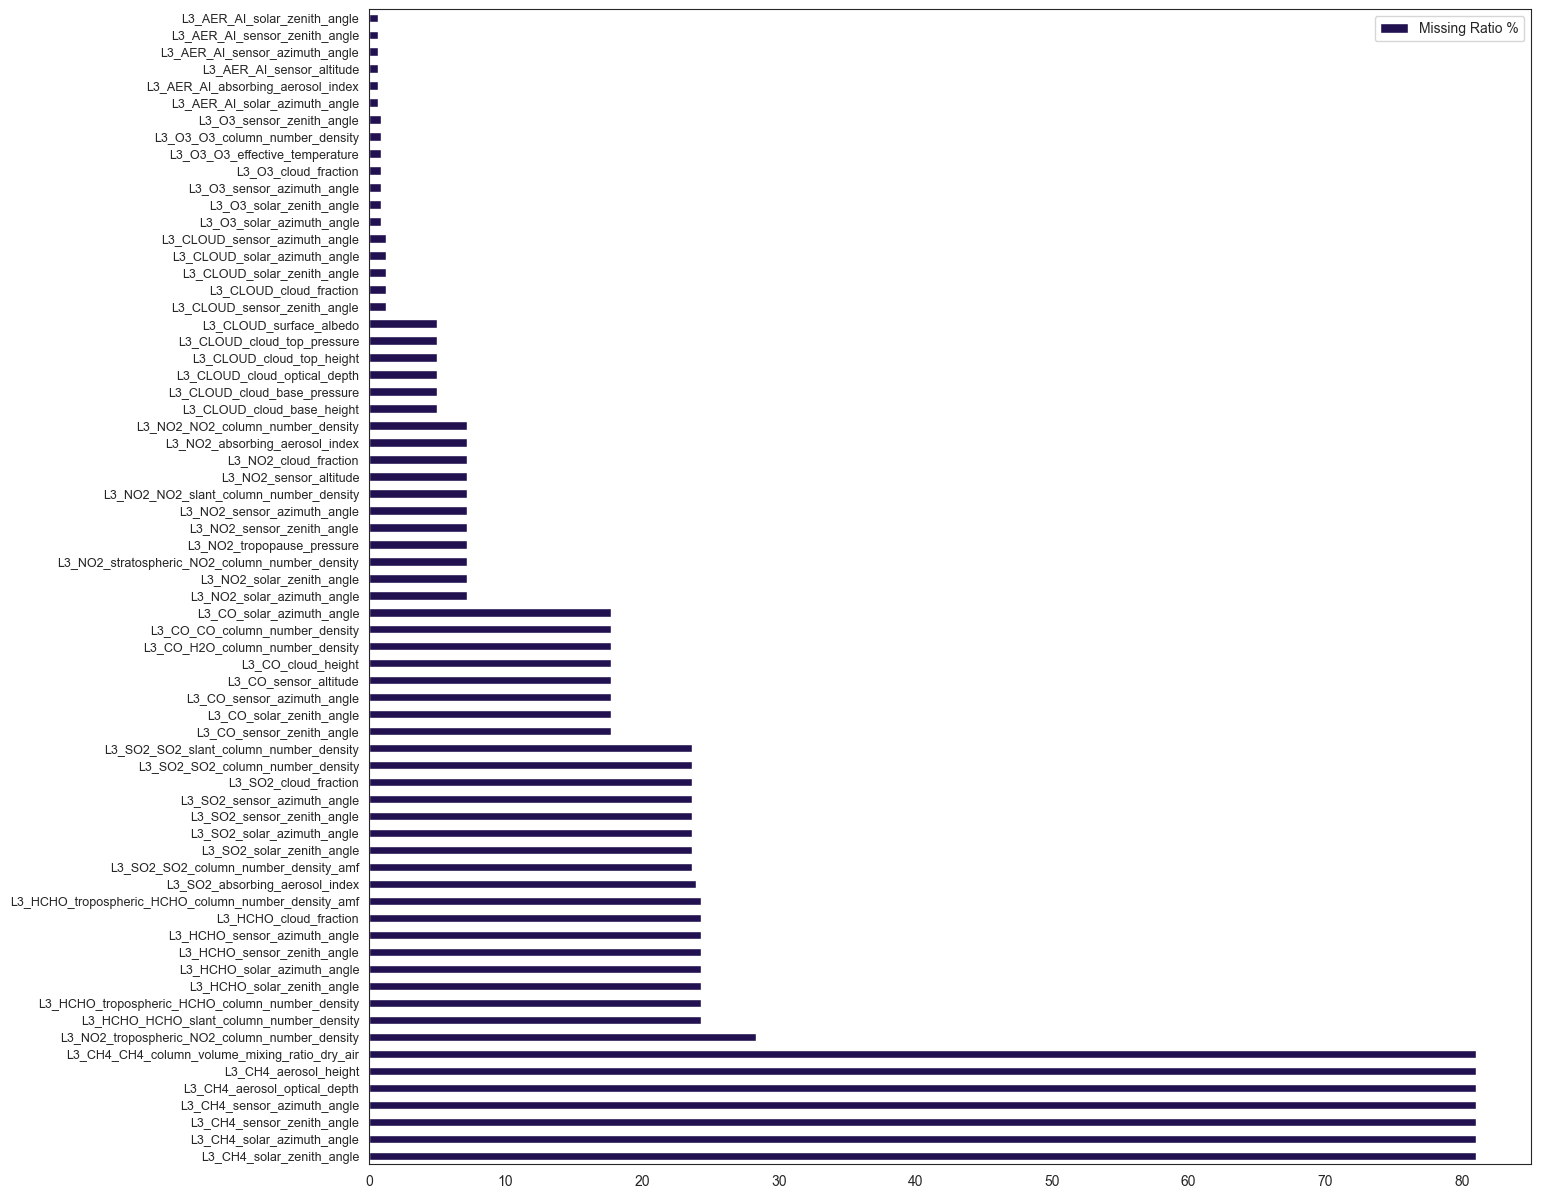

In [20]:
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

In [99]:
# Look for percentage of missing values per row
list_of_missing_columns = df.isnull().sum(axis=1).sort_values(ascending=False)
list_of_missing_columns = list_of_missing_columns[list_of_missing_columns>0]


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  x=list_of_missing_columns))
fig.add


In [21]:
# drop columns with more than 50% missing values
check_ch4 = [col for col in df.columns if 'CH4' in col]
df.drop(columns=check_ch4, axis=1, inplace=True)

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create integer column for weekends
df["IsWeek"] = (df["Date"].dt.weekday < 5).astype(int)

df.drop(columns=['Date', 'Place_ID', 'Place_ID X Date', 'target_min', 'target_max', 'target_variance', 'target_count'], axis=1, inplace=True)

df.head(5)

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,...,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek
0,38.0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,...,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1
1,39.0,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,...,0.000150,0.433957,0.000050,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1
2,24.0,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,0.000170,-1.001242,...,0.000150,0.356925,0.000053,-1.572950,0.082063,-105.201338,49.839714,-78.342701,34.296977,0
3,49.0,6.911948,21.300001,0.00391,23.971857,3.004001,1.099468,0.000083,0.000175,-0.777019,...,0.000227,0.584522,0.000110,-1.239317,0.121261,-104.334066,29.181258,-73.896588,30.545446,0
4,21.0,13.900001,44.700001,0.00535,16.816309,2.621787,2.670559,0.000070,0.000142,0.366323,...,0.000390,0.408047,0.000159,0.202489,0.037919,58.850179,0.797294,-68.612480,26.899694,1


<Axes: >

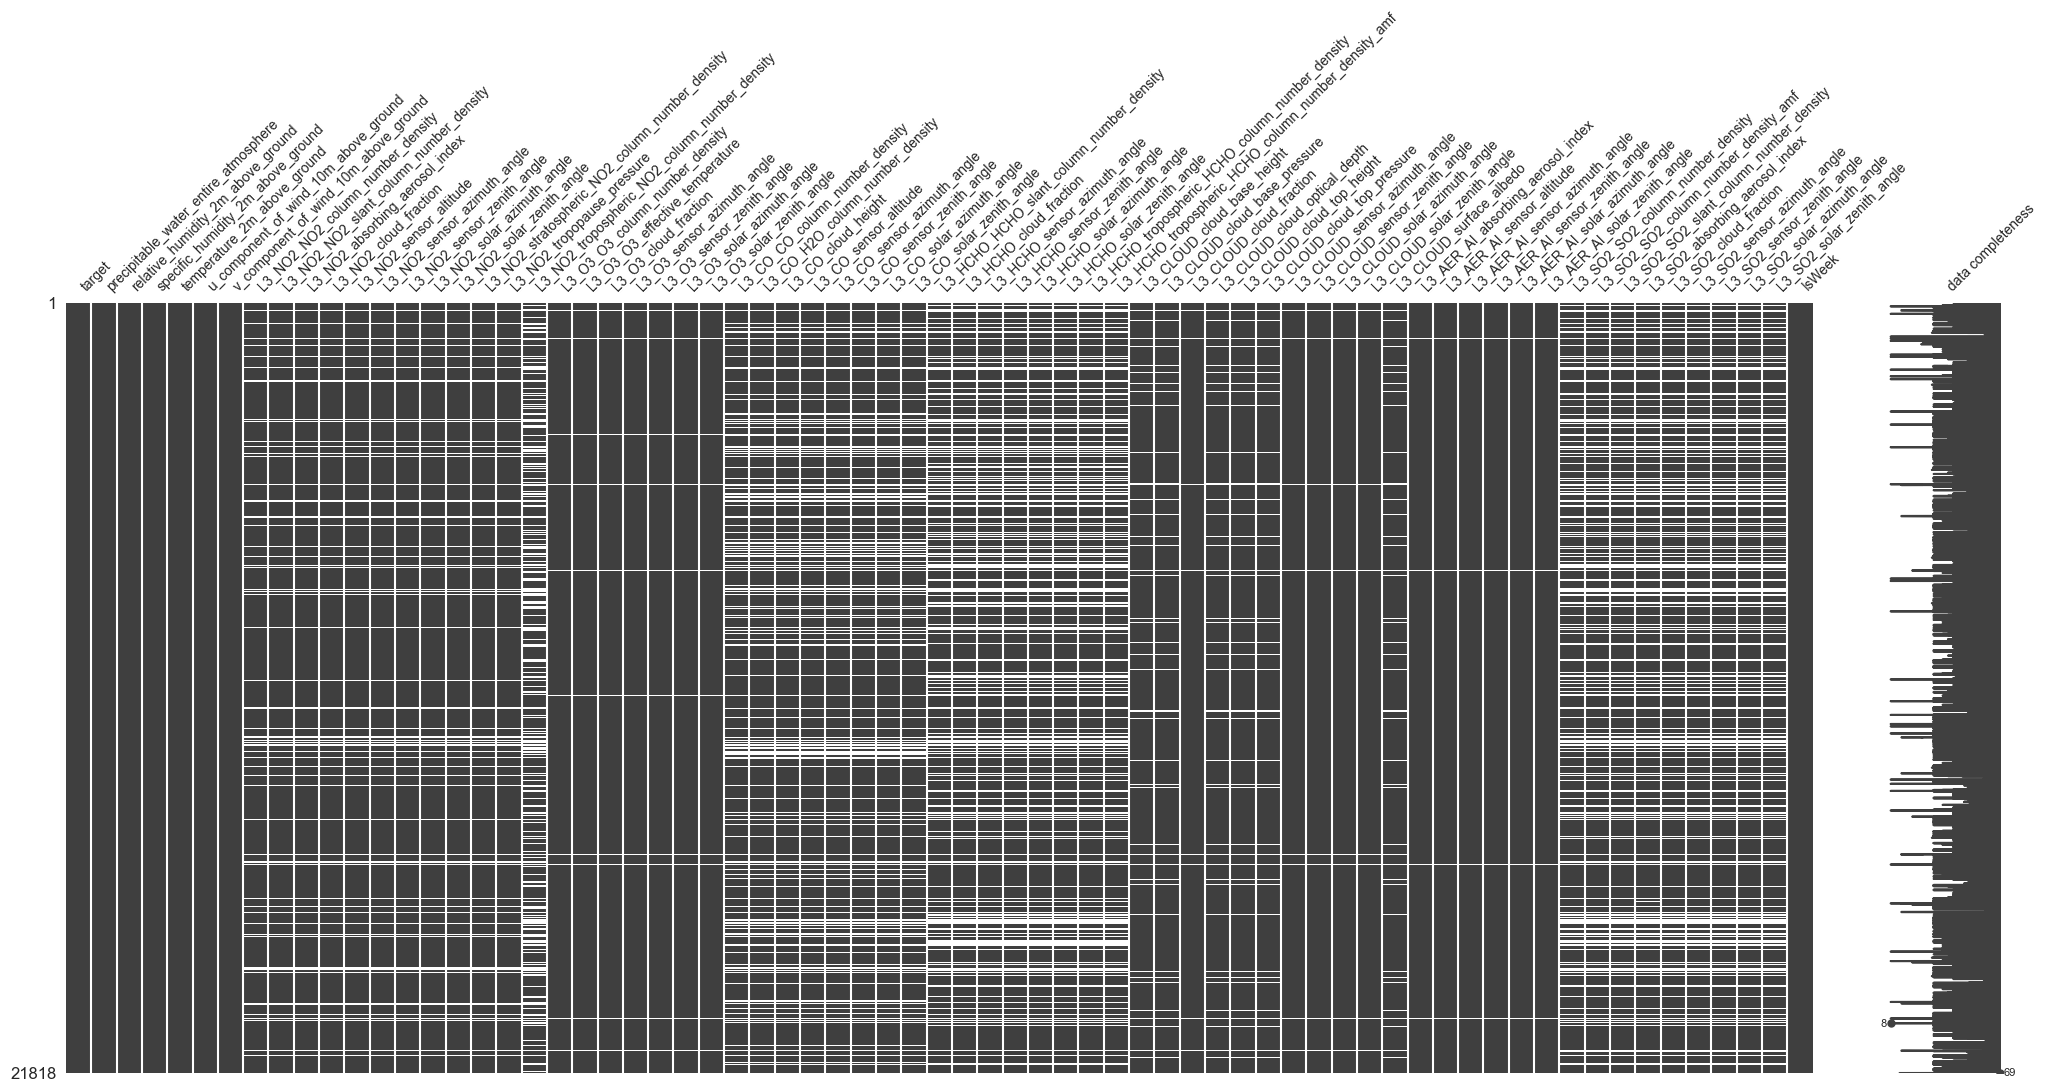

In [22]:
msno.matrix(df.query('IsWeek == 1'), fontsize=10,labels=True)

<Axes: >

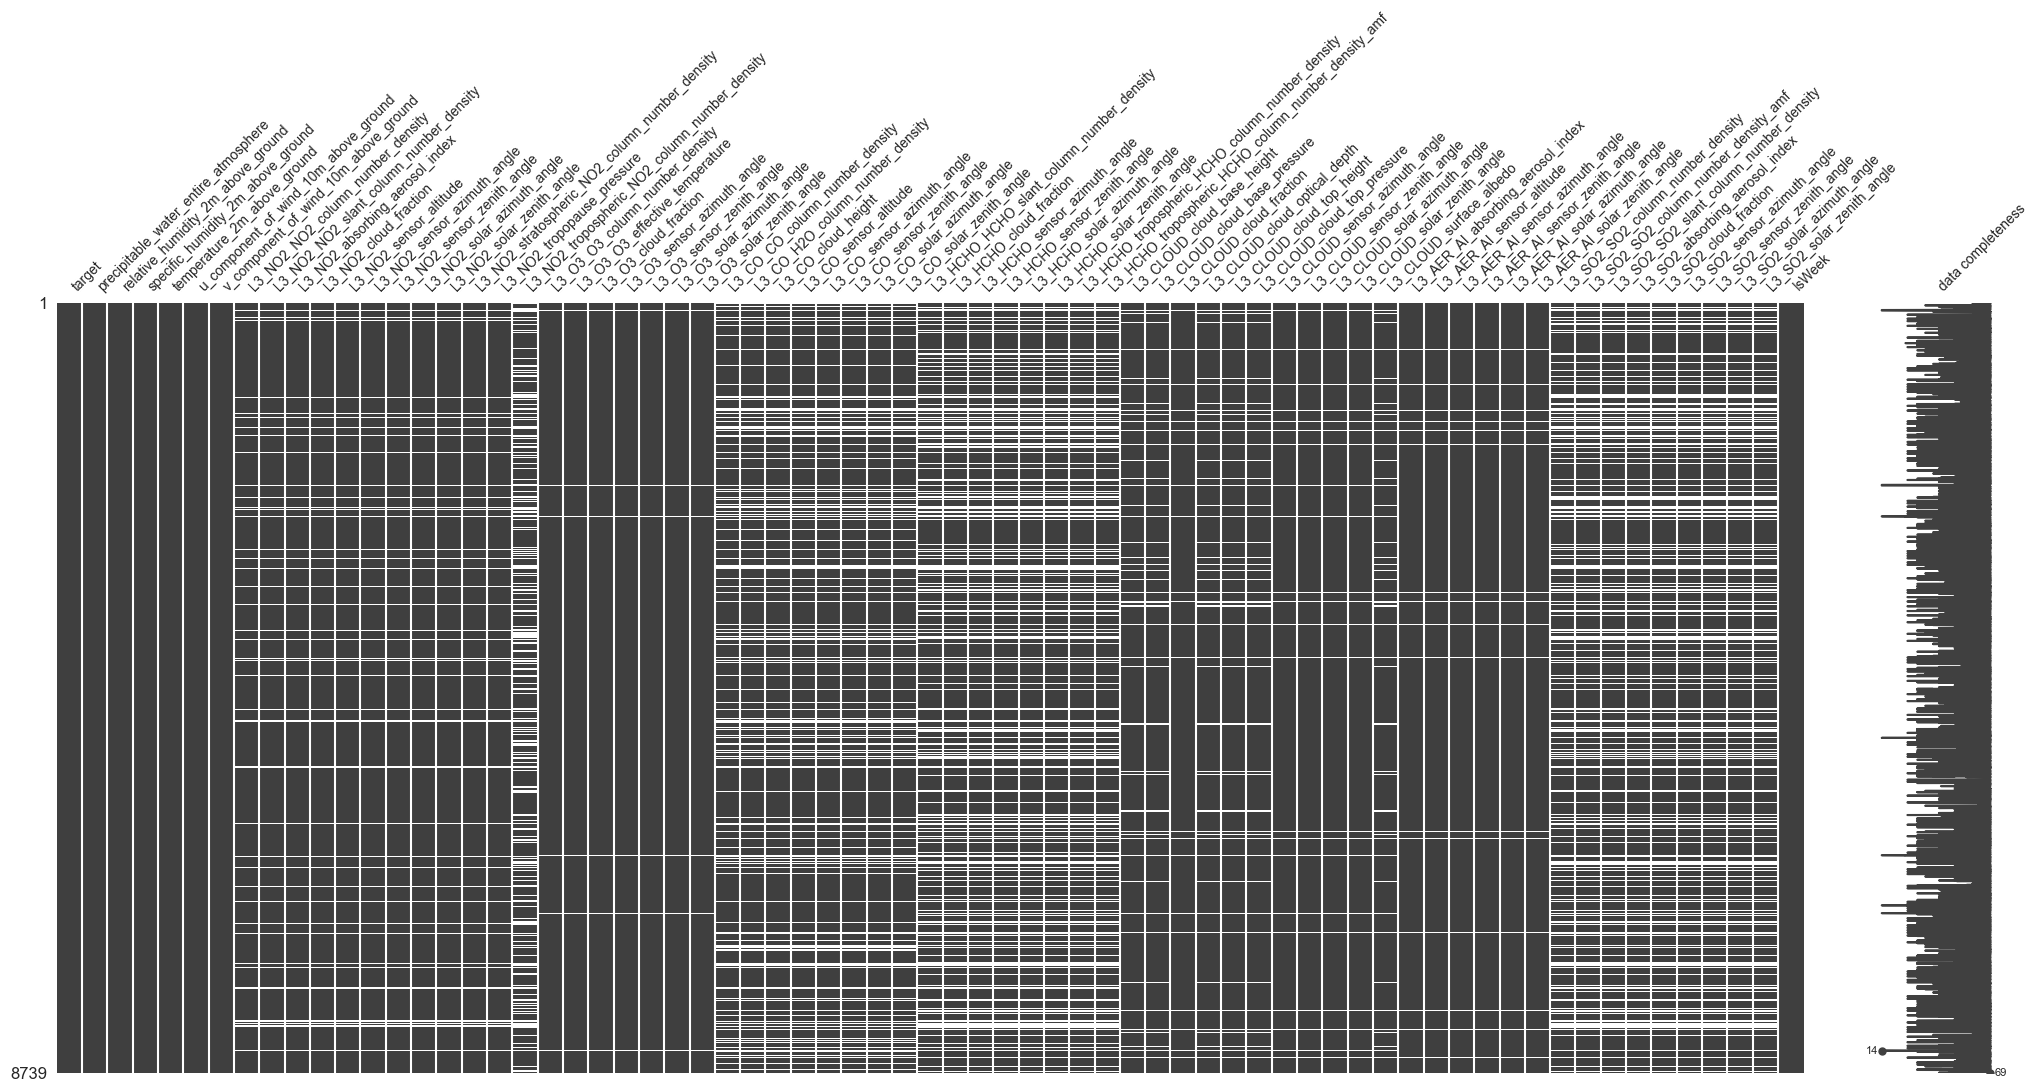

In [23]:
msno.matrix(df.query('IsWeek == 0'), fontsize=10,labels=True)

In [104]:
#removes 0 as outliers
variables_list_0_as_outlier = [
    "L3_NO2_NO2_column_number_density",
    "L3_NO2_NO2_slant_column_number_density",
    "L3_NO2_sensor_altitude",
    "L3_NO2_tropopause_pressure",
    "L3_NO2_solar_zenith_angle",
    "L3_SO2_SO2_column_number_density",
    "L3_SO2_SO2_column_number_density_amf",
    "L3_SO2_SO2_slant_column_number_density",
    "L3_SO2_solar_zenith_angle",
    "L3_O3_O3_column_number_density",
    "L3_O3_O3_effective_temperature",
    "L3_O3_solar_zenith_angle",
    "L3_CO_CO_column_number_density",
    "L3_CO_sensor_altitude",
    "L3_CO_solar_zenith_angle",
    "L3_HCHO_solar_zenith_angle",
    "L3_HCHO_tropospheric_HCHO_column_number_density_amf"
]

df[variables_list_0_as_outlier].replace(0, np.nan, inplace=True)

In [51]:
df_clean = df.query('target < 400')

In [105]:
df.shape

(30557, 69)

In [106]:
df_clean.shape

(30548, 69)

<Axes: >

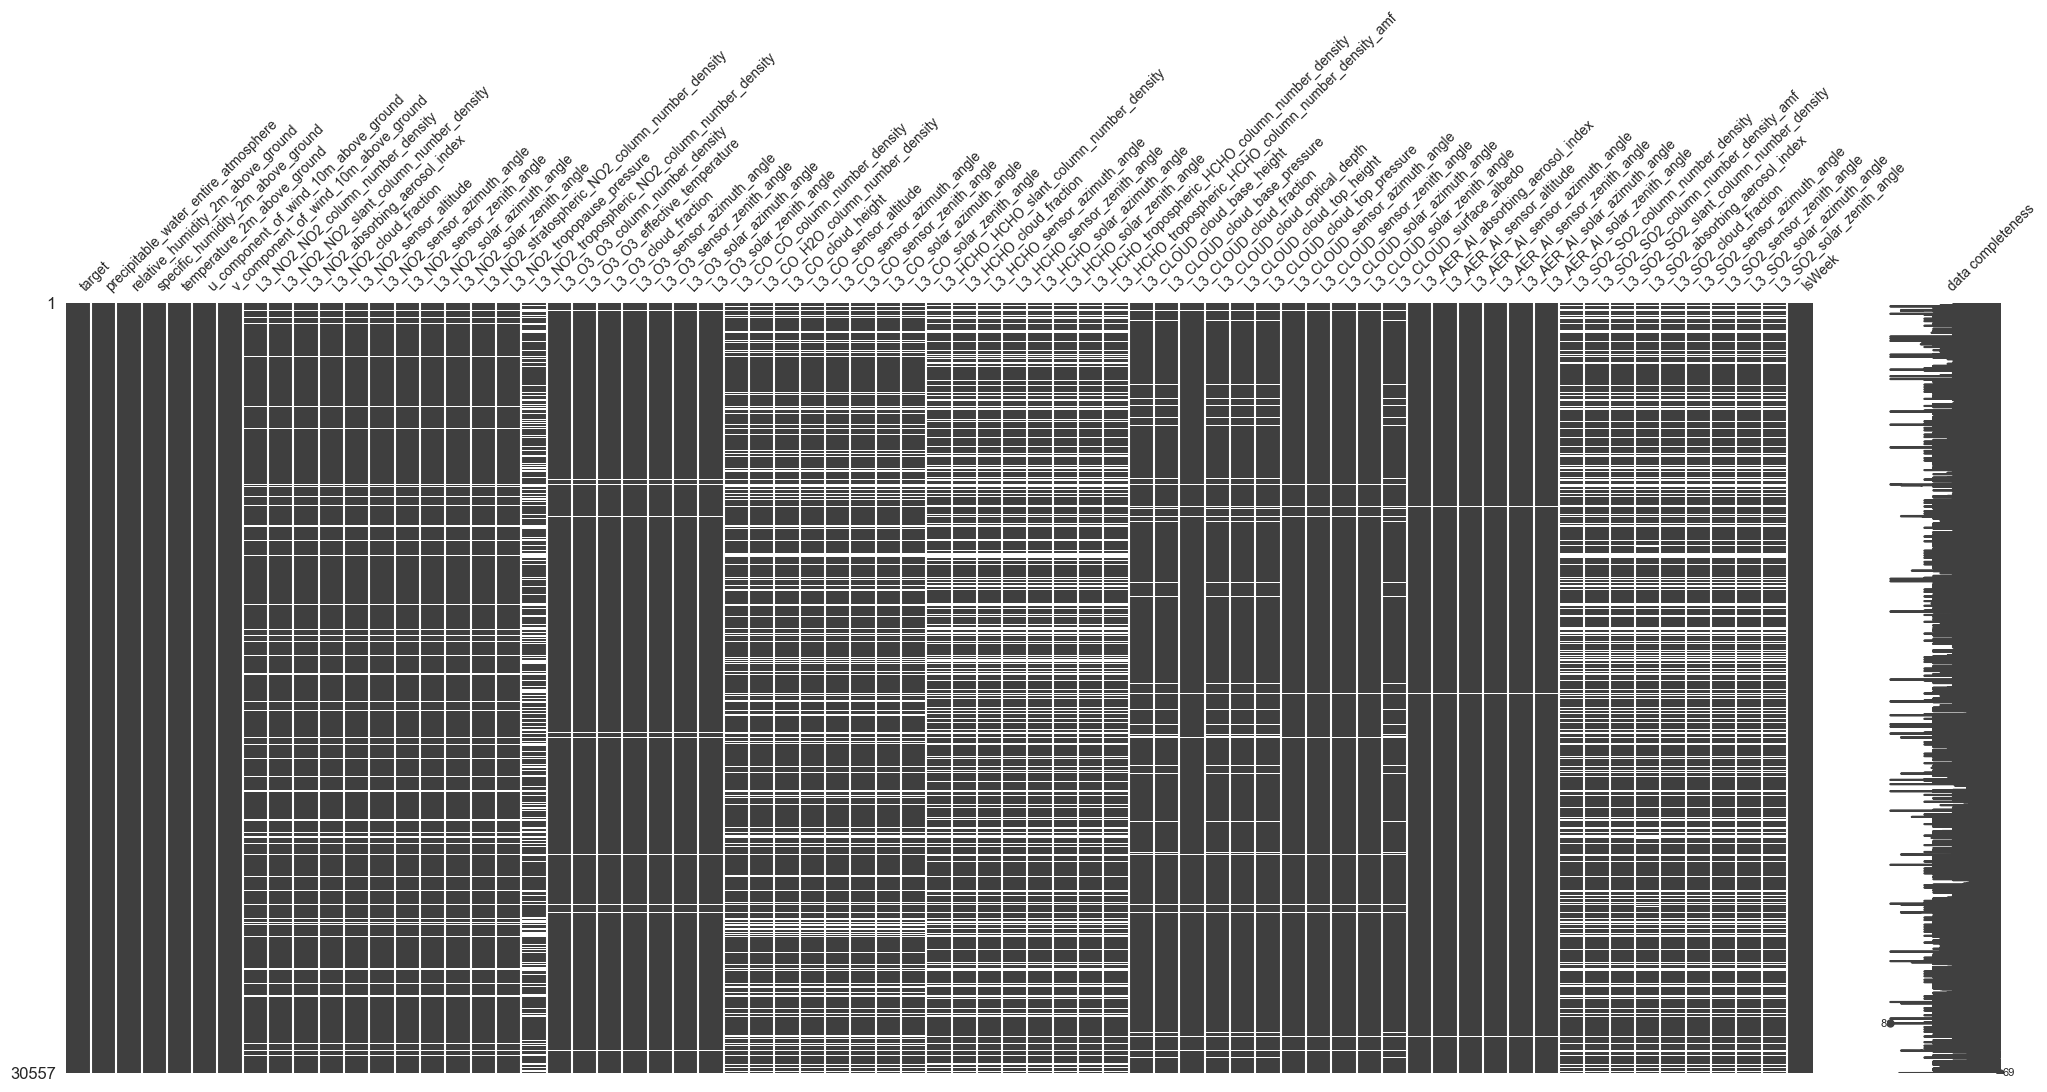

In [108]:
msno.matrix(df, fontsize=10,labels=True)

In [111]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

# Transform y_train

In [ ]:
#from scipy import stats
#yt_train, lmda = stats.boxcox(y_train)
#yt_test, lmda_test = stats.boxcox(y_test)

In [ ]:
#yt_train.shape

(24445,)

## Pipeline

In [137]:
# Pipeline XGBoost Regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

features = list(X.columns)

num_pipeline = Pipeline([
#    ('imputer_num', SimpleImputer(strategy='median')),
    #('imputer_num', IterativeImputer()),    
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, features),
])

pipe_xgbreg = Pipeline([
    ('preprocessor', preprocessor),
    #('xgbreg', xgb.XGBRegressor(eta = 0.15, n_estimators=100,max_depth=7, colsample_bytree=0.8,gamma=5,reg_alpha=0,reg_lambda=10 )) 
    ('xgbreg', xgb.XGBRegressor(n_estimators=100)) 
])

pipe_xgbreg

  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['precipitable_water_entire_atmosphere',
                                                   'relative_humidity_2m_above_ground',
                                                   'specific_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'u_component_of_wind_10m_above_ground',
                                                   'v_component_of_wind_10m_above_ground',
                                                   'L3_NO2_N...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [139]:
X_train.head()

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,...,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek
6892,8.833334,85.666667,0.004207,0.346785,1.029414,-0.472026,0.000053,0.000129,-1.145660,0.353297,...,0.000160,0.610750,0.000092,-1.739053,0.172495,-97.352714,37.327502,-152.324171,45.359265,0
28239,13.400001,41.400002,0.003559,11.904443,0.555712,0.313560,0.000164,0.000150,-1.125127,0.459385,...,-0.000176,0.538113,-0.000071,-2.230005,0.465576,-98.026980,34.337574,-153.965151,46.136408,1
15726,7.021200,75.371429,0.003981,4.801237,3.900238,-5.201962,0.000060,0.000167,-1.203371,0.517568,...,0.000183,0.487513,0.000081,-2.010813,0.405626,-64.544924,63.047693,-151.043520,50.277543,1
1413,24.800001,82.000000,0.007749,13.353082,0.075288,-0.075181,0.000117,0.000214,-1.267236,0.095096,...,-0.000529,0.130800,-0.000071,-1.698147,0.196818,-15.742675,57.787982,11.751409,55.462687,1
30488,12.296144,80.400002,0.003403,1.609796,0.418940,-0.029011,0.000083,0.000176,-0.856076,0.196241,...,0.001043,0.152713,0.000166,-1.631615,0.223540,-93.266035,50.761448,-158.076461,70.878515,0


In [142]:
imp_mean = IterativeImputer(random_state=RSEED)
X_train = imp_mean.fit_transform(X_train)
X_test = imp_mean.transform(X_test)


In [150]:
X_train.shape
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,8.833334,85.666667,0.004207,0.346785,1.029414,-0.472026,0.000053,0.000129,-1.145660,0.353297,...,0.000160,0.610750,0.000092,-1.739053,0.172495,-97.352714,37.327502,-152.324171,45.359265,0.0
1,13.400001,41.400002,0.003559,11.904443,0.555712,0.313560,0.000164,0.000150,-1.125127,0.459385,...,-0.000176,0.538113,-0.000071,-2.230005,0.465576,-98.026980,34.337574,-153.965151,46.136408,1.0
2,7.021200,75.371429,0.003981,4.801237,3.900238,-5.201962,0.000060,0.000167,-1.203371,0.517568,...,0.000183,0.487513,0.000081,-2.010813,0.405626,-64.544924,63.047693,-151.043520,50.277543,1.0
3,24.800001,82.000000,0.007749,13.353082,0.075288,-0.075181,0.000117,0.000214,-1.267236,0.095096,...,-0.000529,0.130800,-0.000071,-1.698147,0.196818,-15.742675,57.787982,11.751409,55.462687,1.0
4,12.296144,80.400002,0.003403,1.609796,0.418940,-0.029011,0.000083,0.000176,-0.856076,0.196241,...,0.001043,0.152713,0.000166,-1.631615,0.223540,-93.266035,50.761448,-158.076461,70.878515,0.0


In [145]:
X_train = pd.DataFrame(X_train)

X_train.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
63    0
64    0
65    0
66    0
67    0
Length: 68, dtype: int64

<Axes: xlabel='66', ylabel='Count'>

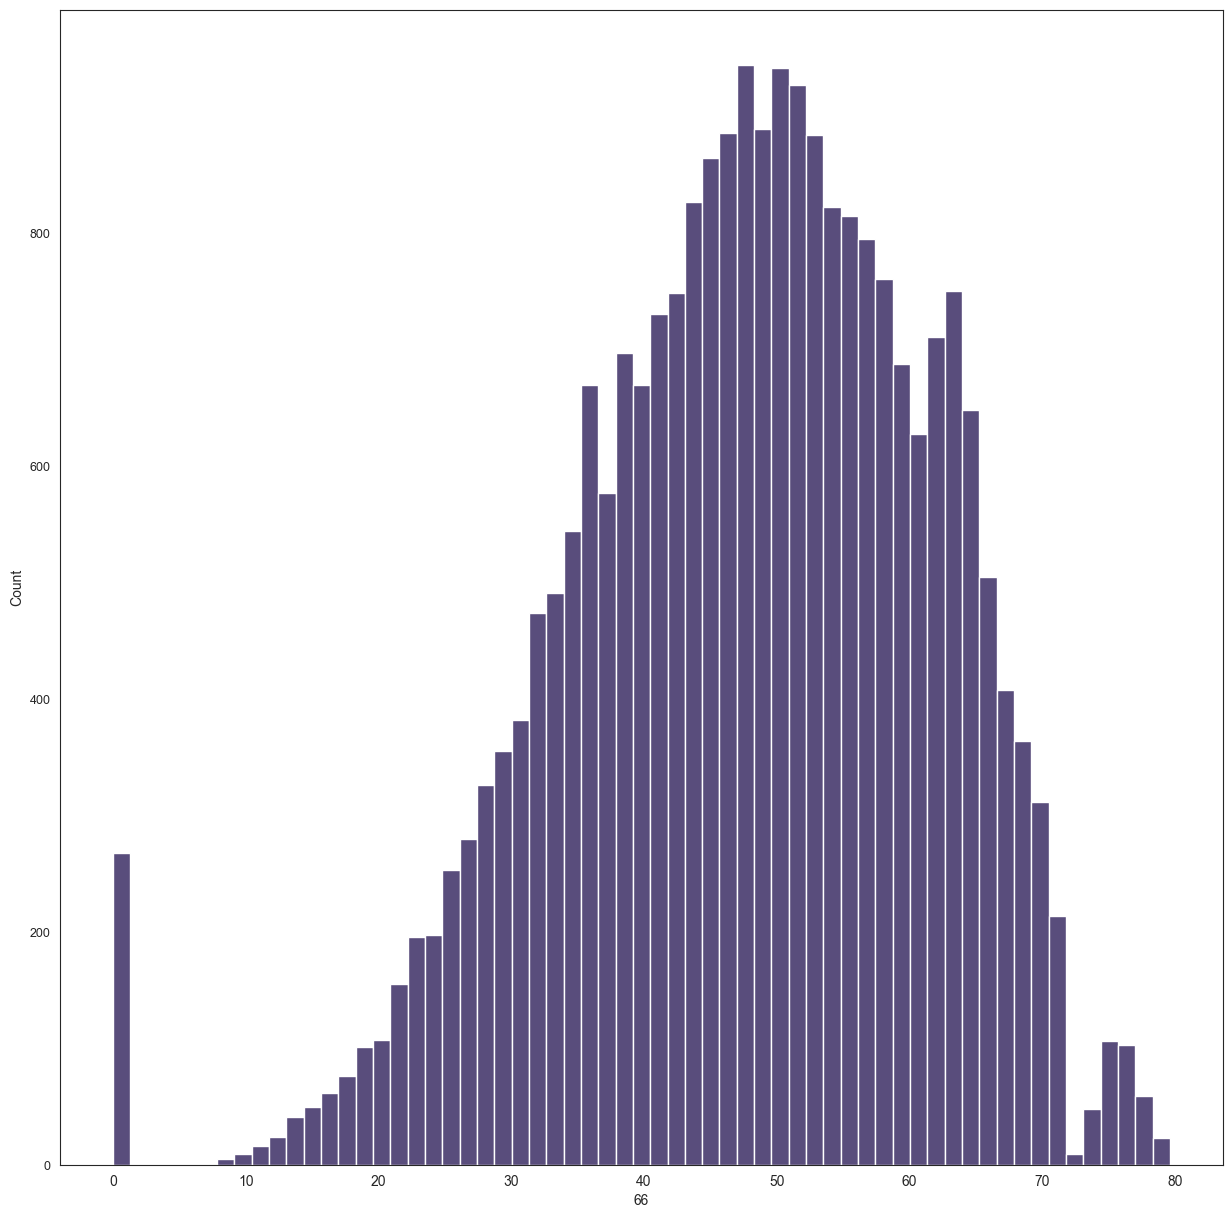

In [155]:
sns.histplot(X_train[66])

In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pipe_xgbreg.fit(X_train, y_train)

y_pred_test = pipe_xgbreg.predict(X_test)
y_pred_train = pipe_xgbreg.predict(X_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse = mean_squared_error(y_train, y_pred_train)
rmse = mse ** 0.5
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
              
            
print(f"TEST: RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")
print(f"train: RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

TEST: RMSE: 30.46, MAE: 20.63, R²: 0.578
train: RMSE: 18.20, MAE: 13.27, R²: 0.849


## RandomSearch

In [114]:
param_xgbreg = {
               #'xgbreg__n_estimators': [30],
               'xgbreg__learning_rate': [0.08, 0.1, 0.14], 
               'xgbreg__max_depth': [3, 7],
               #'xgbreg__colsample_bytree': [0.7, 0.8, 1],
               #'xgbreg__gamma': [0.2, 0.3, 0.5],
               #'xgbreg__reg_alpha': [0],
               #'xgbreg__reg_lambda': [5, 10]
             }

random_search_xbreg = RandomizedSearchCV(pipe_xgbreg, param_distributions=param_xgbreg, cv=5, scoring='neg_mean_absolute_error', 
                            verbose=1, n_jobs=-1, n_iter=50)

random_search_xbreg.fit(X_train, y_train)
random_search_xbreg.best_params_, random_search_xbreg.best_score_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/lkj/Documents/neuefische/ds-AirPollution/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/lkj/Documents/neuefische/ds-AirPollution/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/lkj/Documents/neuefische/ds-AirPollution/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/lkj/Documents/neuefische/ds-AirPollution/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/lkj/Documents/neuefische/ds-AirPollution/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] 

({'xgbreg__max_depth': 7, 'xgbreg__learning_rate': 0.14}, -20.191057055167875)

In [115]:
best_model = random_search_xbreg.best_estimator_
y_test_predicted = best_model.predict(X_test)
y_train_predicted = best_model.predict(X_train)

print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted)))
print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted)))


mean_absolute_error: 20.10
mean_absolute_error_train: 13.68


In [116]:
random_search_xbreg.cv_results_ 

{'mean_fit_time': array([100.91553807, 112.38788223,  94.62705998, 105.63143163,
         86.83411851,  84.33336129]),
 'std_fit_time': array([0.48060777, 4.04600428, 2.11716672, 1.96504637, 6.59454068,
        1.15680486]),
 'mean_score_time': array([0.53180413, 0.64222274, 0.62099643, 0.59195857, 0.43904147,
        0.25377779]),
 'std_score_time': array([0.14257588, 0.1093649 , 0.11327252, 0.12209703, 0.07280524,
        0.00568182]),
 'param_xgbreg__max_depth': masked_array(data=[3, 7, 3, 7, 3, 7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbreg__learning_rate': masked_array(data=[0.08, 0.08, 0.1, 0.1, 0.14, 0.14],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'xgbreg__max_depth': 3, 'xgbreg__learning_rate': 0.08},
  {'xgbreg__max_depth': 7, 'xgbreg__learning_rate': 0.08},
  {'xgbreg__max_depth': 3, 'xgbreg__learning_rat

# GRIDSEARCH Finetuning

In [ ]:
#GRIDSEARCH

param_xgbreg_grid = {
              'xgbreg__n_estimators': [50],
              'xgbreg__learning_rate': [0.1], 
              'xgbreg__max_depth': [10],
              'xgbreg__colsample_bytree': [0.8],
              'xgbreg__gamma': [5],
              'xgbreg__reg_alpha': [0],
              'xgbreg__reg_lambda': [10]
            }

grid_search_xbreg = GridSearchCV(pipe_xgbreg, param_grid=param_xgbreg_grid, cv=5, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1)

grid_search_xbreg.fit(X_train, y_train)
grid_search_xbreg.best_params_, grid_search_xbreg.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'xgbreg__colsample_bytree': 0.8,
  'xgbreg__gamma': 5,
  'xgbreg__learning_rate': 0.1,
  'xgbreg__max_depth': 10,
  'xgbreg__n_estimators': 50,
  'xgbreg__reg_alpha': 0,
  'xgbreg__reg_lambda': 10},
 -20.04695228283282)

In [ ]:
best_model = grid_search_xbreg.best_estimator_
# y_test_predicted_grid = best_model.predict(X_test)
# y_train_predicted_grid = best_model.predict(X_train)

# print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_grid)))
# print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_grid)))

# Error Analyse

In [117]:
residuals = y_train-y_train_predicted 

Text(0.5, 1.0, 'Residuals vs. Predicted')

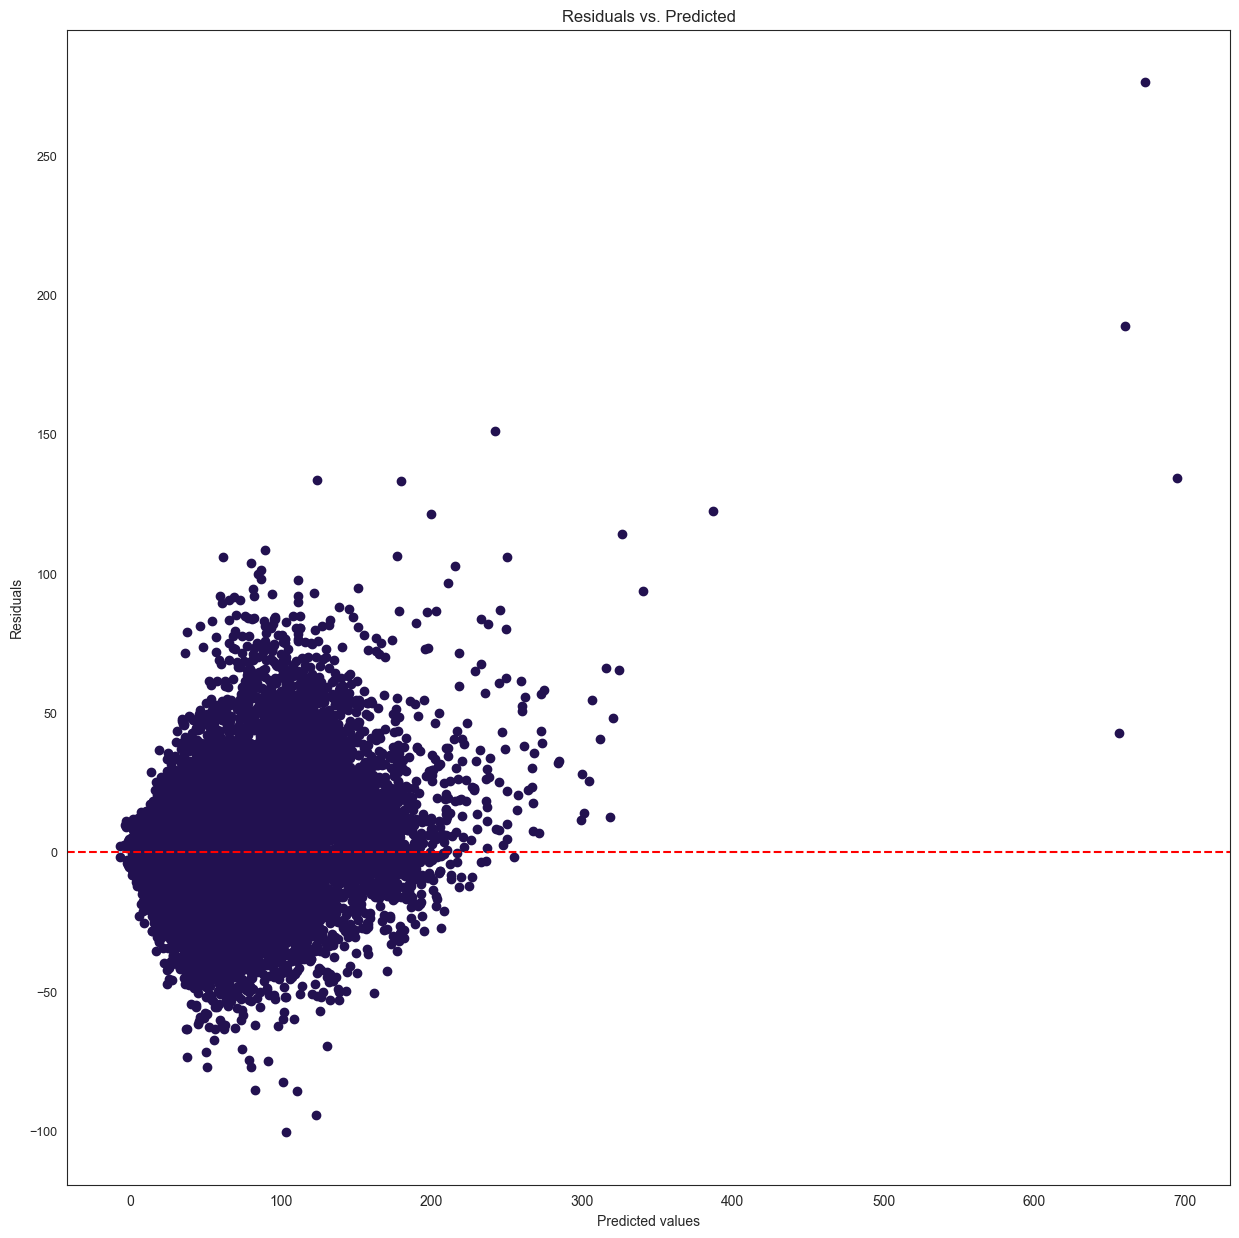

In [118]:
##
residuals = y_train-y_train_predicted 

plt.scatter(x=y_pred_train,y=residuals)

plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")

Text(0.5, 1.0, 'Distribution of Residuals')

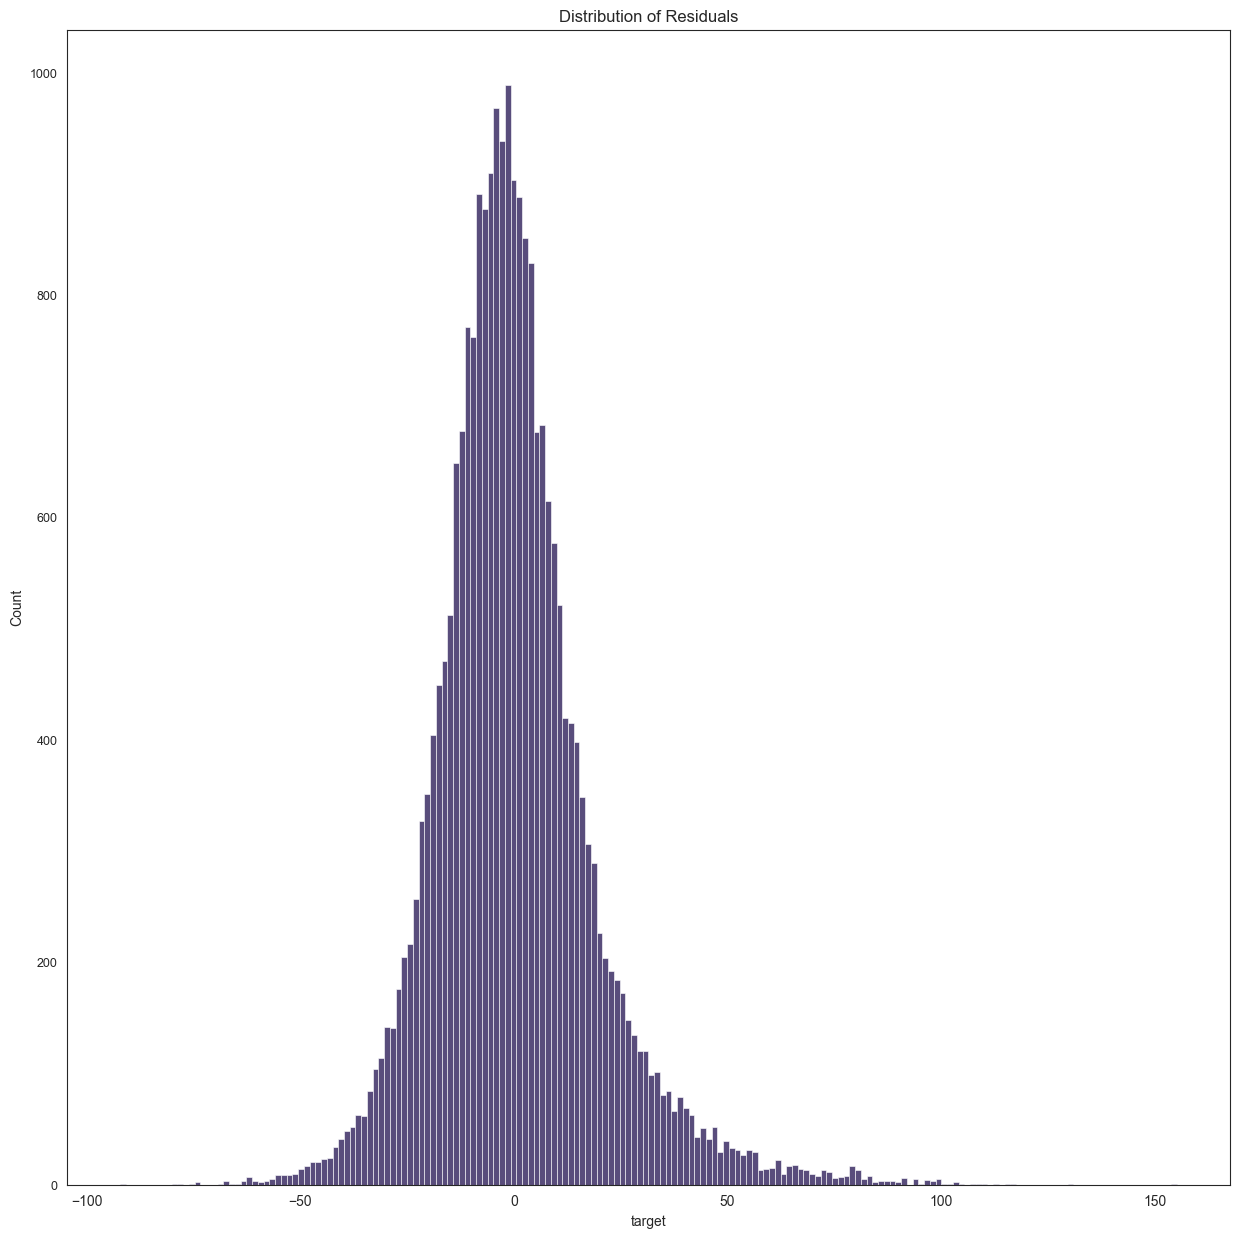

In [67]:
sns.histplot(residuals)

plt.title("Distribution of Residuals")


Text(0.5, 1.0, 'Actual vs. Predicted')

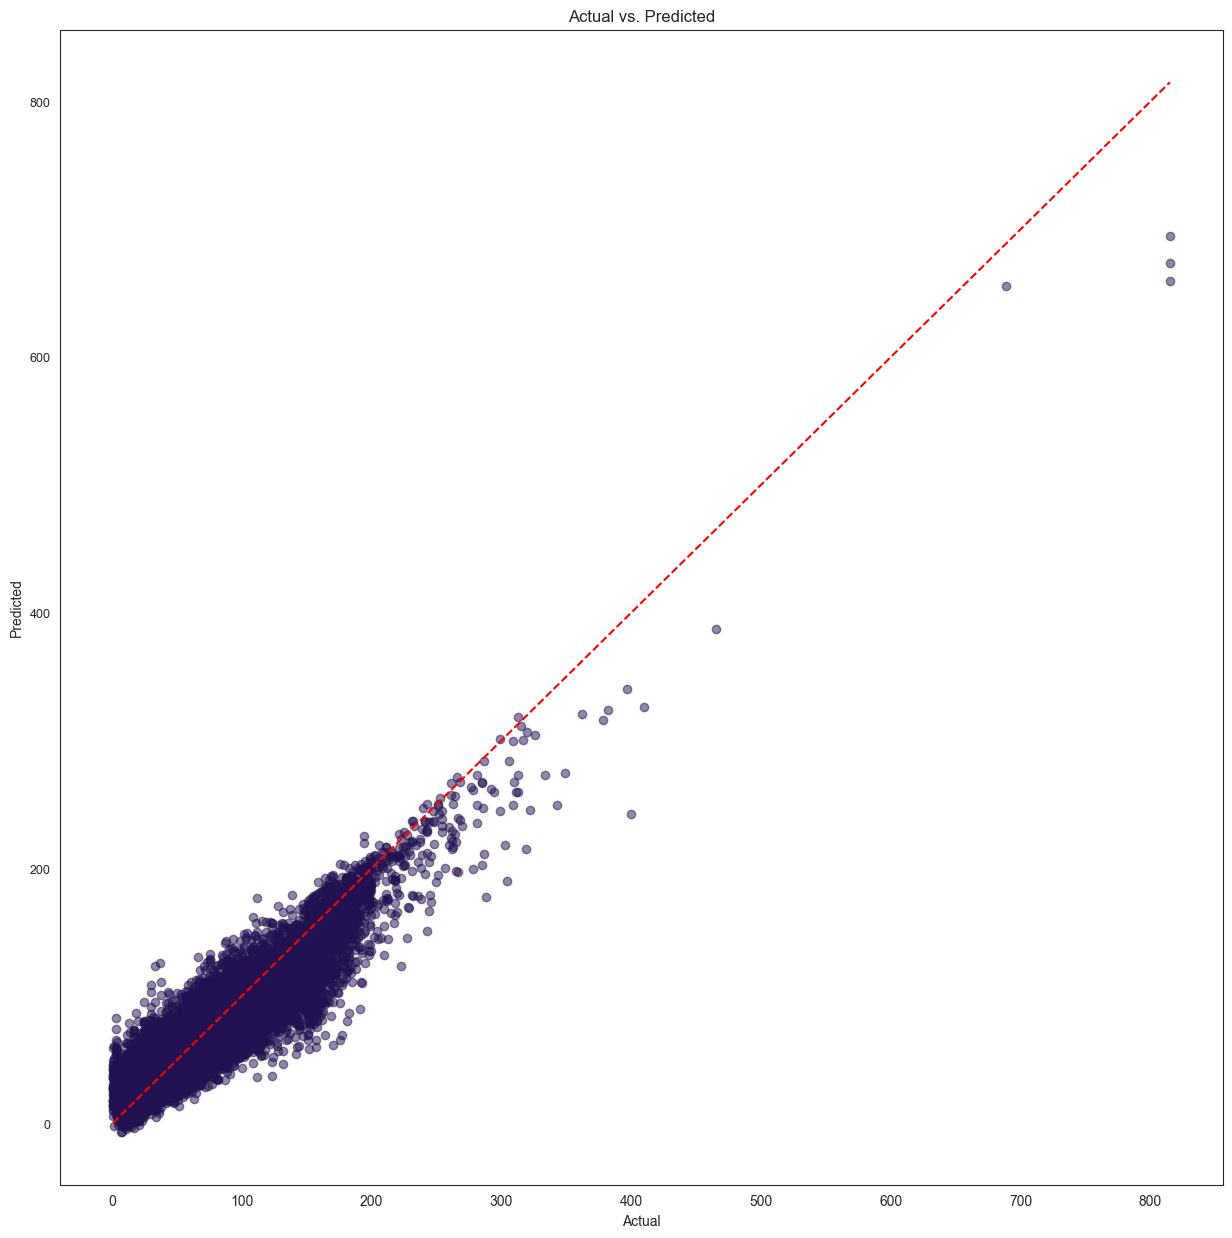

In [119]:
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")

Text(0.5, 1.0, 'Feature Importances')

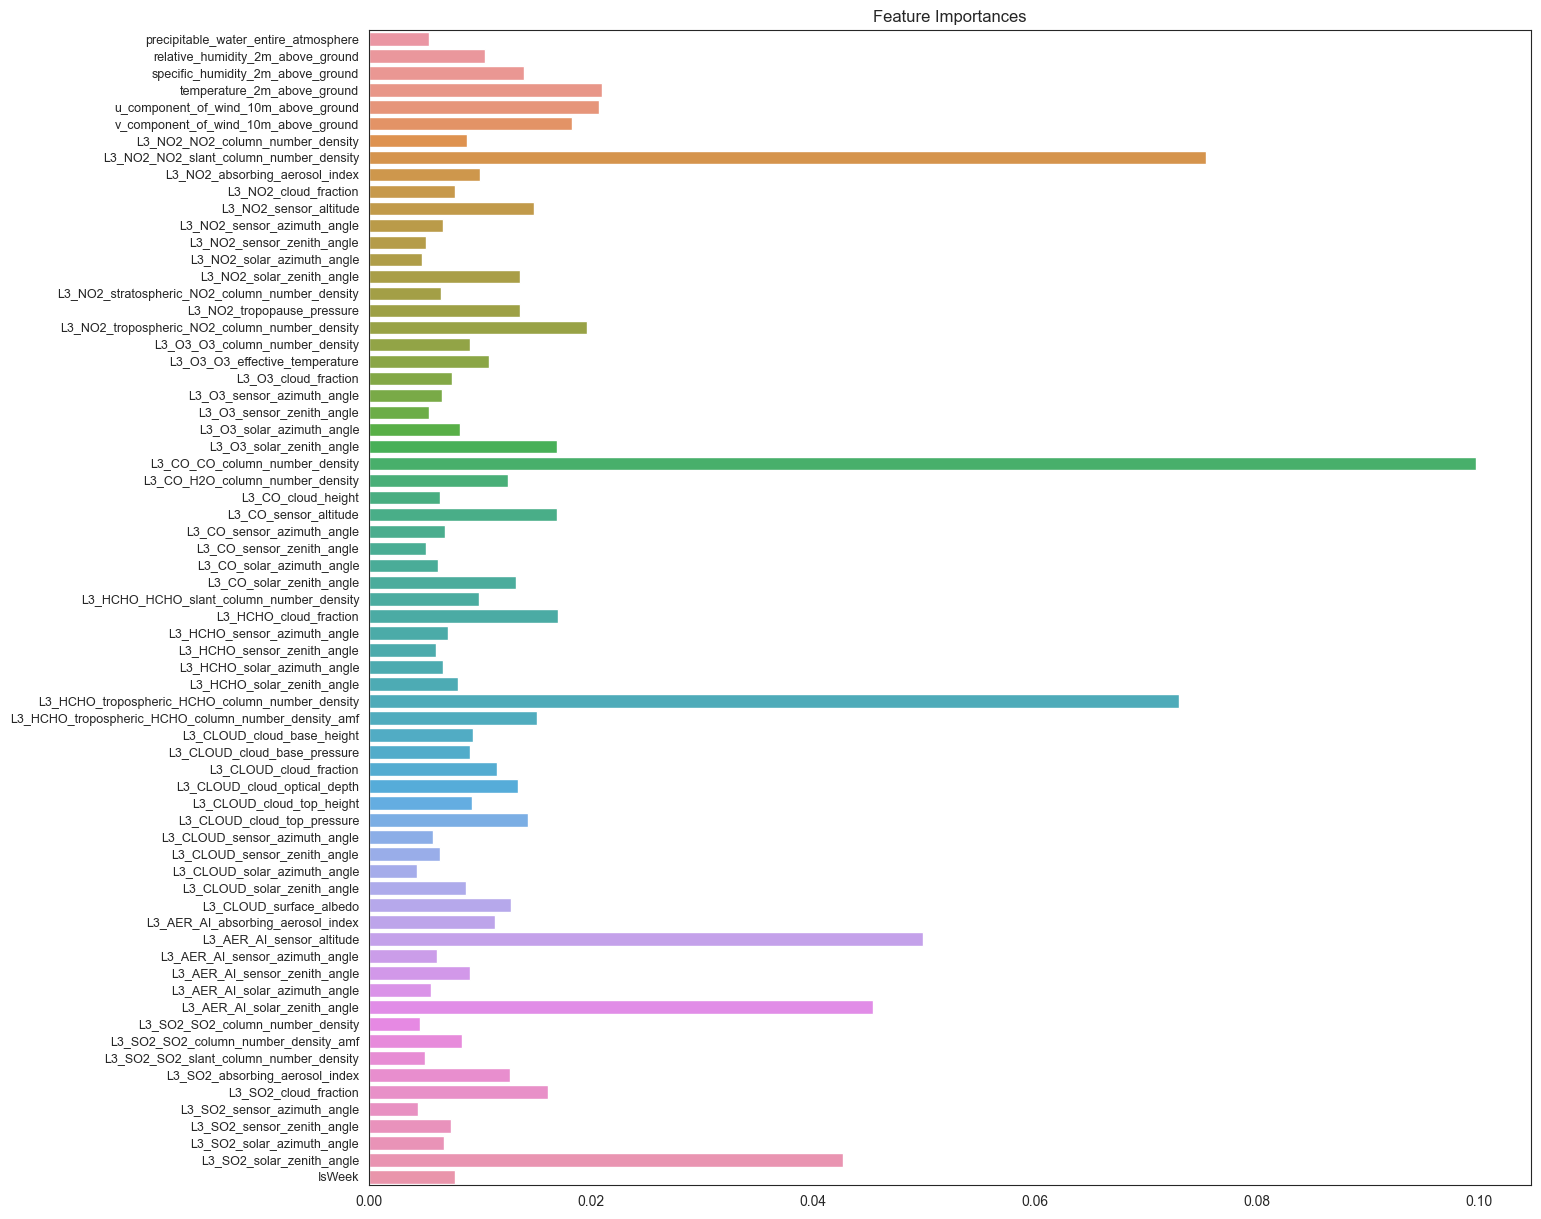

In [121]:
reg = best_model.named_steps['xgbreg']
importances = reg.feature_importances_
feature_names = X_train.columns
# Visualize
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")

In [122]:
error = np.abs(y_pred_train - y_train)

In [124]:
df_erroranalyse = X_train.copy()
df_erroranalyse['y_true'] = y_train
df_erroranalyse['y_pred'] = y_pred_train
df_erroranalyse['abs_error'] = error
df_erroranalyse["rel_error"] = error/y_pred_train#df_erroranalyse["y_true"]

In [125]:
df_erroranalyse.fillna(df.median(),inplace=True)

In [126]:
top_fehler = df_erroranalyse.sort_values(by='abs_error', ascending=False).head(10)
top_fehler

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,...,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek,y_true,y_pred,abs_error,rel_error
17607,11.700000,56.200001,0.004330,9.991022,0.135728,0.520559,0.000144,0.000187,-1.272483,0.283986,...,0.294302,70.431013,36.955452,-168.578931,55.190426,0,400.0,242.358978,157.641022,0.650444
4456,12.528572,29.471429,0.006174,22.243524,4.833642,3.617324,0.000046,0.000119,-0.814485,0.278440,...,0.359894,-94.545837,57.442645,-142.722236,43.375964,1,815.0,659.860596,155.139404,0.235109
4453,8.471429,23.442857,0.004474,20.786388,1.051566,2.760782,0.000059,0.000121,-0.659029,0.002930,...,0.003499,76.041288,8.056621,-157.709027,39.146939,0,815.0,673.220276,141.779724,0.210599
4465,9.671429,15.171429,0.004068,26.412230,-0.850091,-2.750546,0.000077,0.000157,-1.496870,0.050011,...,0.080639,70.281991,46.851716,-165.142246,33.428196,1,815.0,694.669800,120.330200,0.173219
25821,30.000000,56.200001,0.007160,18.047632,-1.260254,-0.768225,0.000081,0.000115,-1.299578,0.770400,...,0.481359,68.619904,53.206413,-171.004639,42.395958,1,304.0,189.786667,114.213333,0.601799
24412,8.000000,82.900002,0.003602,2.073053,-0.283298,-0.492500,0.000245,0.000178,-1.560445,0.381811,...,0.499668,70.985140,30.638717,-170.136025,55.247110,1,288.0,177.469086,110.530914,0.622818
23509,17.671658,85.200005,0.005622,7.390497,1.047396,1.655449,0.000044,0.000096,-1.631291,0.703565,...,0.458198,-101.904256,16.610162,-165.685350,62.134143,1,176.0,65.783432,110.216568,1.675446
23530,15.500000,60.100002,0.004252,8.394708,1.932415,1.178616,0.000079,0.000122,-1.480115,0.625137,...,0.190333,-14.308518,37.918838,-156.637162,47.445010,1,170.0,62.001503,107.998497,1.741869
20798,10.700000,36.200001,0.002990,10.620203,1.302151,-0.329910,0.000057,0.000145,-0.681740,0.805762,...,0.190333,-14.308518,37.918838,-156.637162,47.445010,1,177.0,69.999481,107.000519,1.528590
30306,2.540000,85.520004,0.002774,-3.525165,-1.440015,1.188001,0.000092,0.000266,-1.031753,0.276805,...,0.320802,-97.048526,38.207160,-161.085406,66.865396,1,319.0,215.438065,103.561935,0.480704


In [127]:
top_fehler.columns

Index(['precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
       'L3_O3_sensor_zenith_angle', 'L3_O3_solar_azimuth_angle',
       'L3_O3_solar_zenith_angle', 'L3_CO_CO_column_number_densi

<Axes: xlabel='y_true', ylabel='abs_error'>

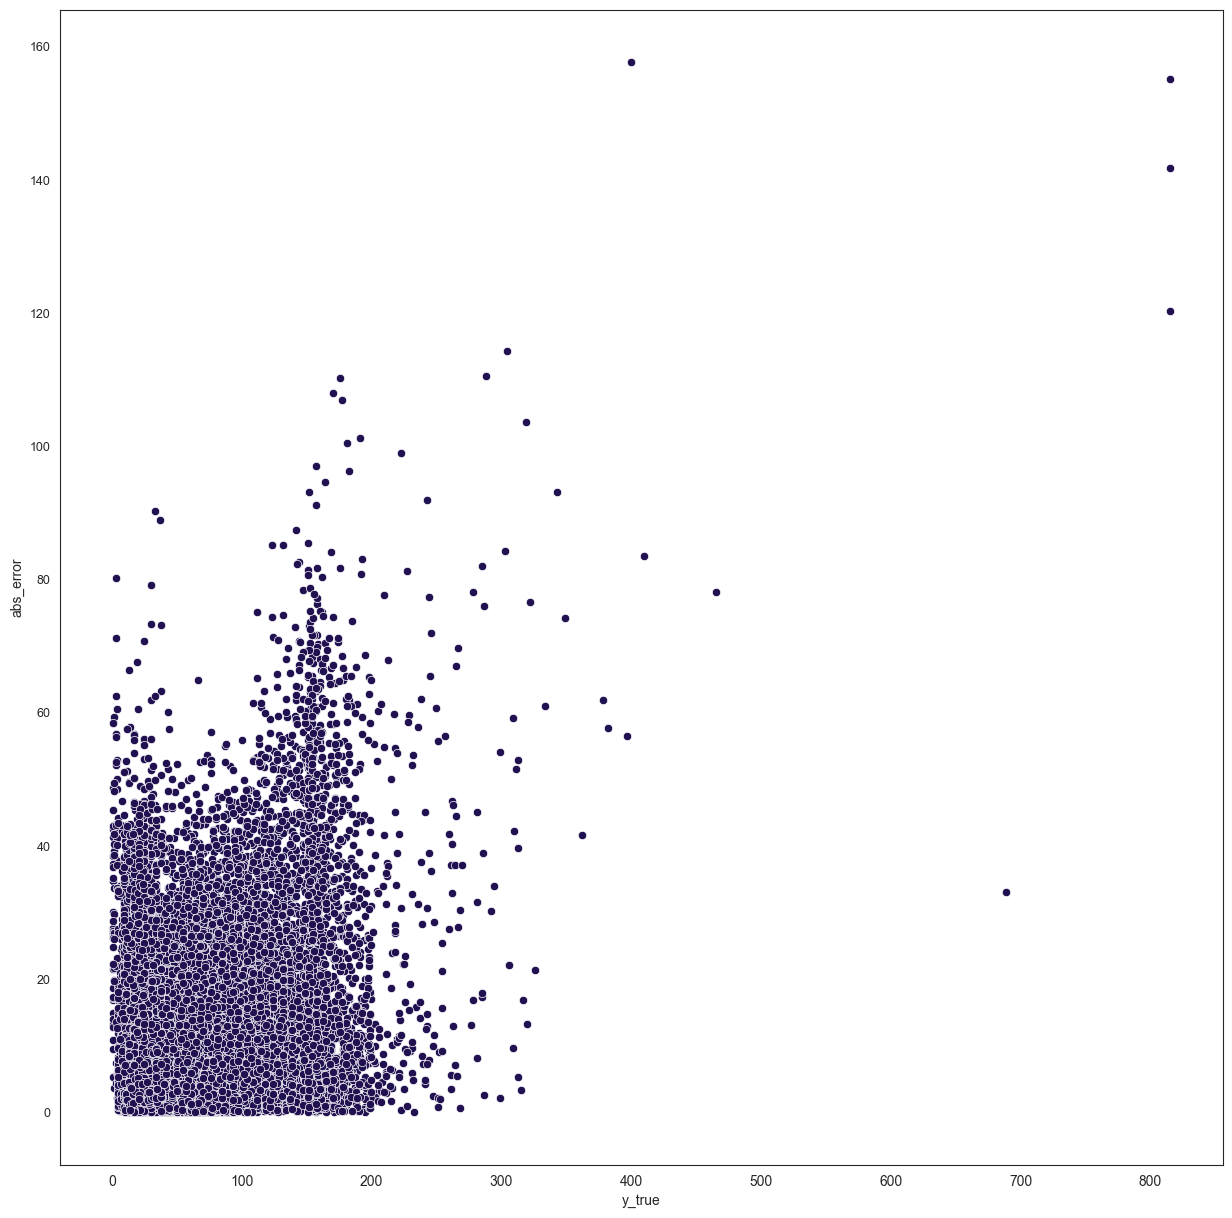

In [129]:
sns.scatterplot(data=df_erroranalyse, x="y_true", y="abs_error")


In [132]:
best_feature

['L3_NO2_NO2_slant_column_number_density',
 'L3_CO_CO_column_number_density',
 'L3_HCHO_tropospheric_HCHO_column_number_density',
 'L3_AER_AI_sensor_altitude',
 'L3_AER_AI_solar_zenith_angle',
 'L3_SO2_solar_zenith_angle',
 'y_true',
 'y_pred',
 'abs_error',
 'rel_error']

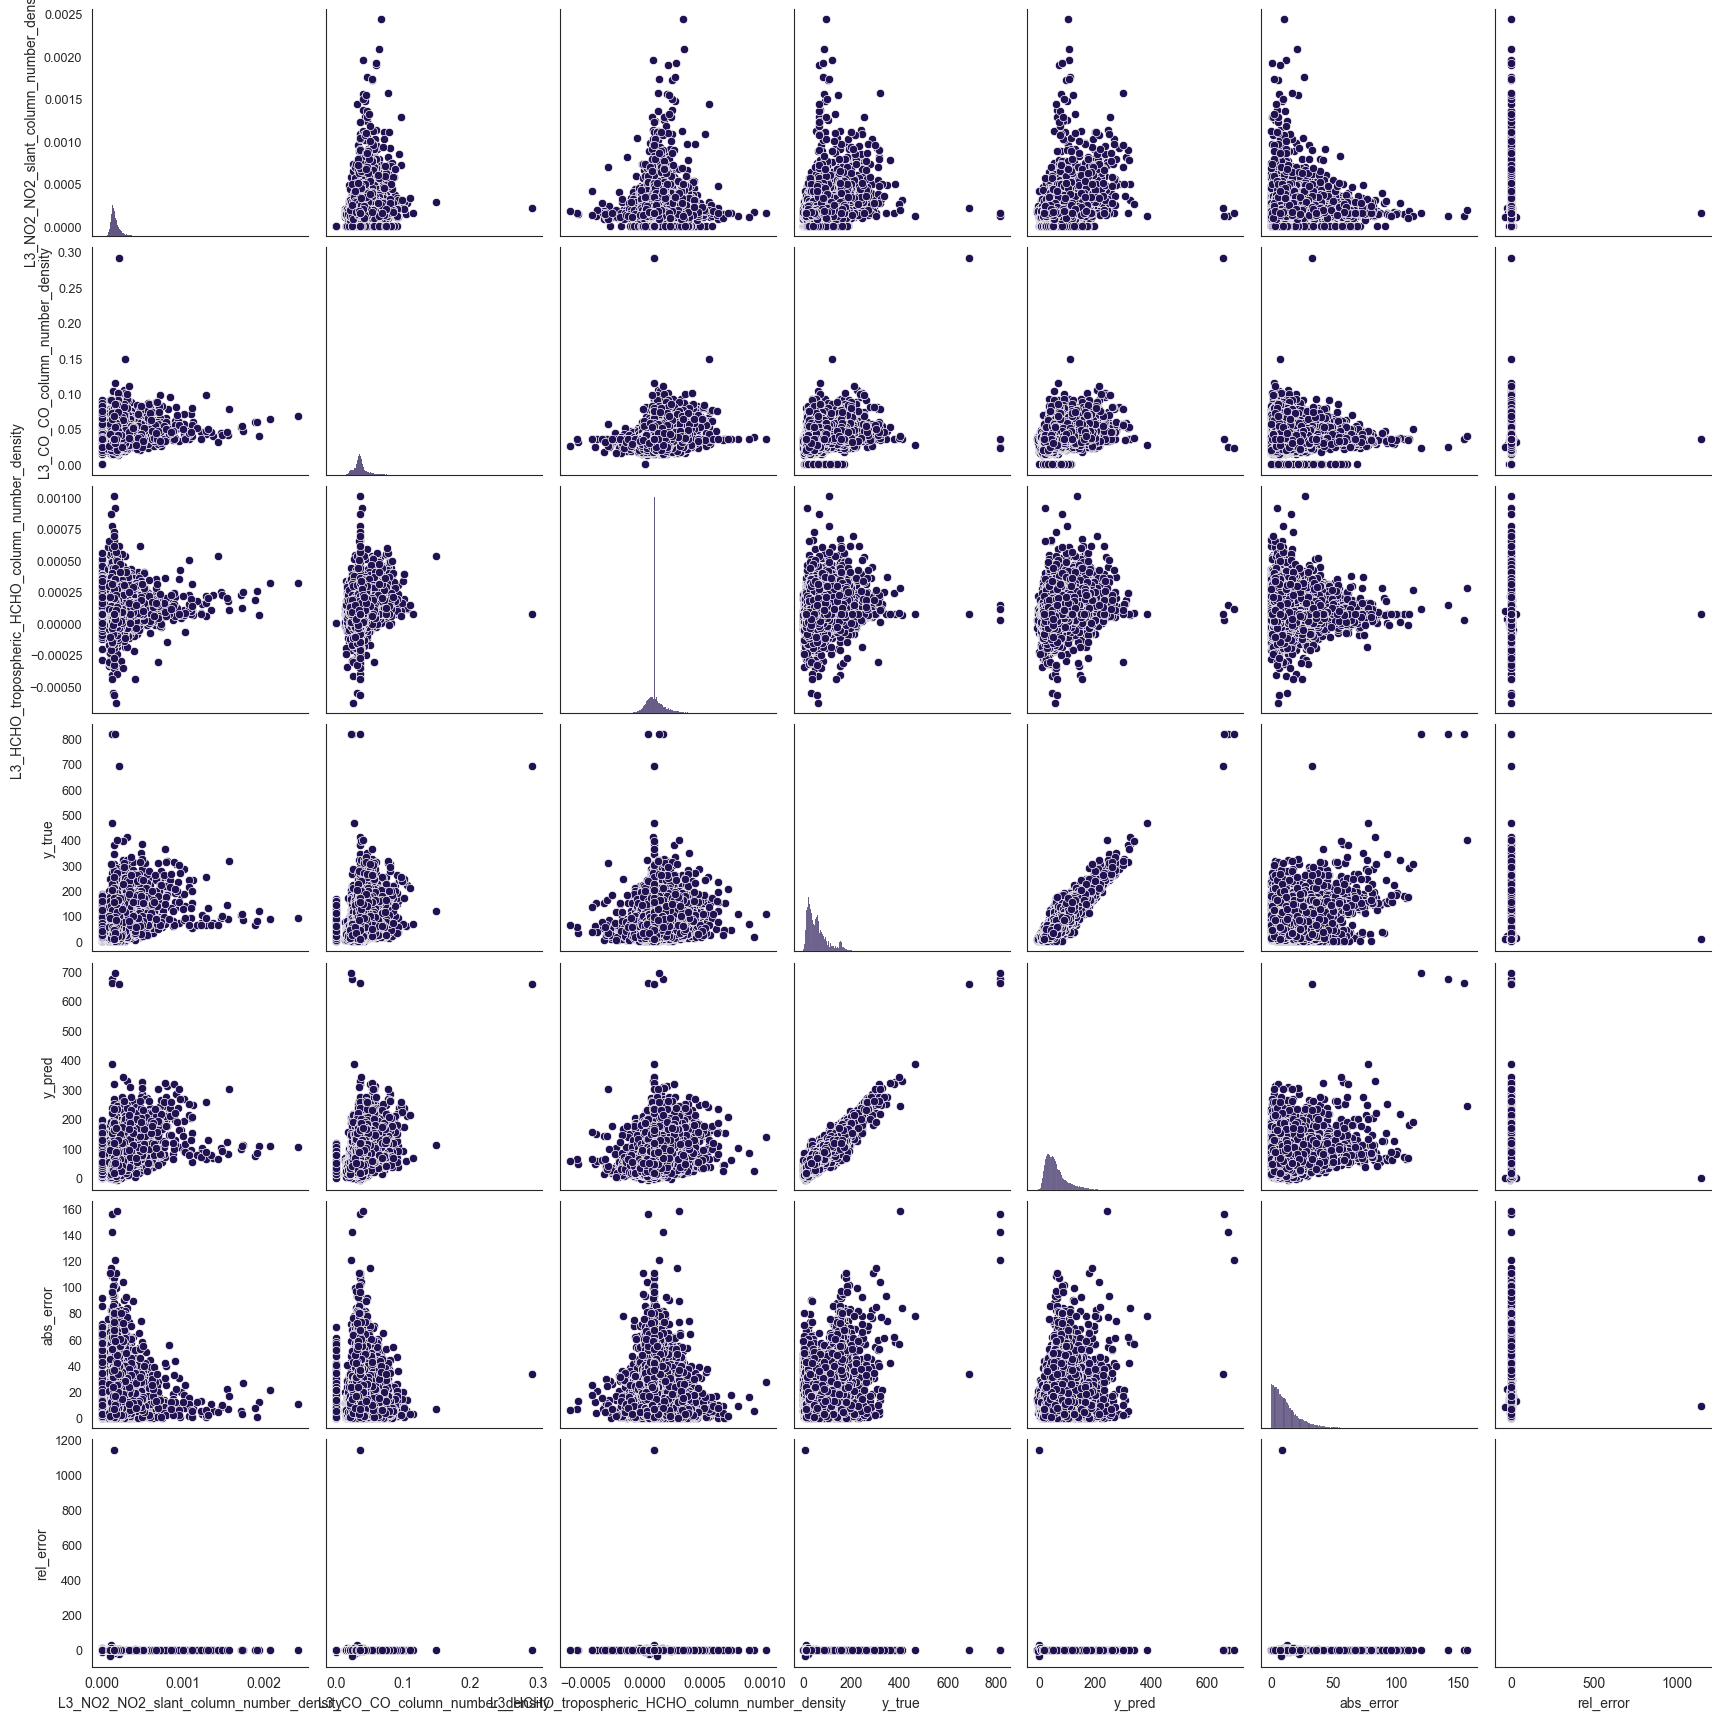

In [133]:
best_feature=list(feature_names[importances>0.06])
lst=['y_true','y_pred','abs_error','rel_error']
best_feature.extend(lst)

# best_feature

sns.pairplot(data=df_erroranalyse[best_feature])


# Plot test data


Text(0.5, 1.0, 'Actual vs. Predicted')

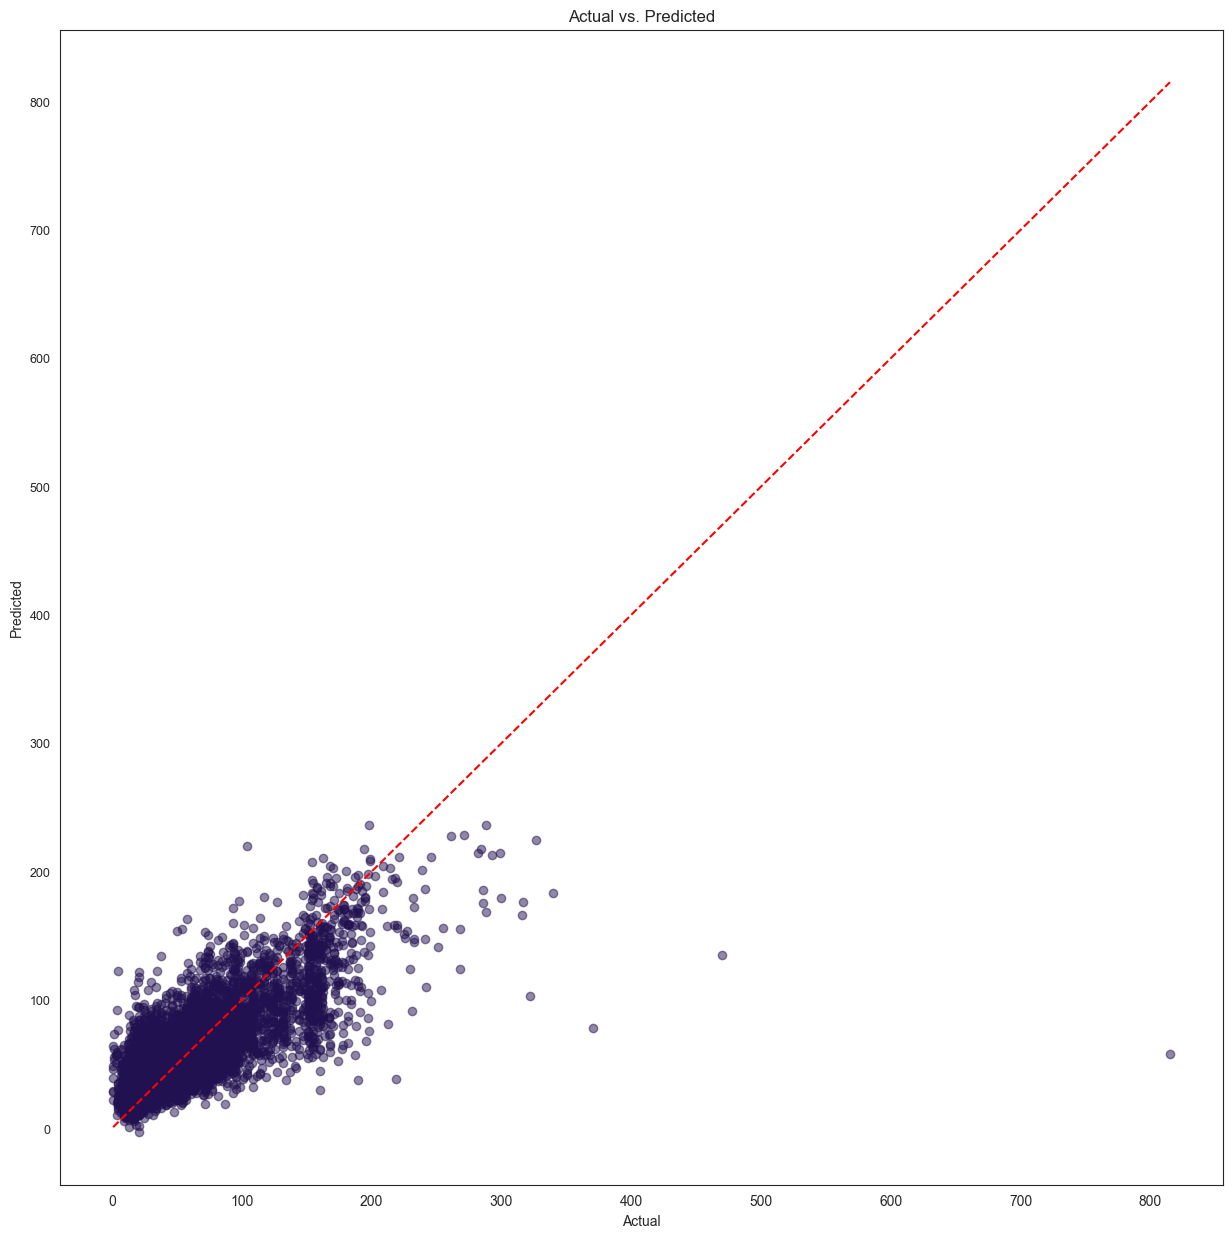

In [ ]:
plt.scatter(y_test, y_test_predicted, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted TEST data ")

In [ ]:
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")